In [2]:
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.ticker as mtick
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

import pandas as pd
import numpy as np
import streamlit as st
# Machine Learning Metrics
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix

# Models
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

# Feature Selection
from sklearn.feature_selection import SelectKBest, f_regression

# Feature Importance
from sklearn.inspection import permutation_importance

import optuna
import warnings
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
warnings.filterwarnings("ignore")



c:\Users\lauro.telles\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



Here, the objective was to preprocess the data effectively, ensuring it is suitable for modeling. This involved steps such as cleaning the data to remove any inconsistencies or missing values, preparing it for analysis. Then, we partitioned the dataset into training and testing samples to evaluate the model's performance. Additionally, we applied scaling techniques to normalize the features, ensuring they are on a similar scale for optimal modeling. Finally, we removed outliers from the dataset to prevent them from disproportionately influencing the model's training process and subsequent predictions.

In [12]:
dados_train = pd.read_csv(r'C:\Users\lauro.telles\Desktop\Web Scrapping\Taxi trip\train.csv')
dados_train = dados_train.iloc[:50000,:]






dados_train_id = dados_train.iloc[:,0]
dados_train = dados_train.iloc[:,[4,5,6,7,8,9,10]]
dados_train['store_and_fwd_flag'] = np.where(dados_train['store_and_fwd_flag']=='Y',1,0)

z_threshold = 3
z_scores = stats.zscore(dados_train)
outlier_indices = (np.abs(z_scores)>z_threshold).any(axis=1)
dados_train= dados_train[~outlier_indices]

train = dados_train.iloc[0:40000,:]
teste = dados_train.iloc[40001:50000,:]

X_train = train.drop(columns='trip_duration')
y_train_not_scaled = train.iloc[:,-1].values.reshape(-1,1)

X_test = teste.drop(columns='trip_duration')
y_test_not_scaled = teste.iloc[:,-1].values.reshape(-1,1)



scaler = MinMaxScaler()
y_test = scaler.fit_transform(y_test_not_scaled)
y_train = scaler.fit_transform(y_train_not_scaled)






array([[0.06184444],
       [0.09017845],
       [0.28919766],
       ...,
       [0.06797439],
       [0.12409753],
       [0.1245062 ]])

Now, in an effort to refine our model, we will select the most significant features based on the results of the p-value analysis.

In [13]:

k_best = SelectKBest(score_func=f_regression,k=6)

X_train_kbest = k_best.fit_transform(X_train,y_train)
X_test_kbest = k_best.fit_transform(X_test,y_test)

feature_indices = k_best.get_support(indices=True)
feature_names = X_train.columns[feature_indices]

p_value = k_best.pvalues_

features = []

for feature, pvalue in zip(feature_names,p_value):
    if pvalue<2:
        features.append(feature)

X_train_kbest = X_train[features]
X_test_kbest = X_test[features]


Here, we will experiment with various potential models to determine which yields the most favorable results in terms of R2 and RMSE values

In [14]:
"""
#Modeling

# regressors = [
#     LinearRegression(),
#     Ridge(random_state=7),
#     ExtraTreesRegressor(random_state=7),
#     GradientBoostingRegressor(random_state=7),
#     KNeighborsRegressor(),
#     XGBRegressor(),
#     LGBMRegressor(random_state=7),
#     CatBoostRegressor(random_state=7),
#     AdaBoostRegressor(random_state=7),
#     RandomForestRegressor(random_state=7)
# ]

# for reg in regressors:
#     reg.fit(X_train_kbest,y_train)
#     y_pred = reg.predict(X_test_kbest)

#     r2 = r2_score(y_test,y_pred)
#     rmse = mean_squared_error(y_test,y_pred,squared=False)
#     st.warning(f'{type(reg).__name__}:R2 = {r2:.2F}, Root Mean Squared Error = { rmse:.2f}')
#     print((f'{type(reg).__name__}:R2 = {r2:.2F}, Root Mean Squared Error = { rmse:.2f}'))
"""
model = LGBMRegressor(random_state=7)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test,y_pred)

rmse = mean_squared_error(y_test,y_pred,squared=False)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1026
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 5
[LightGBM] [Info] Start training from score 0.103508


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


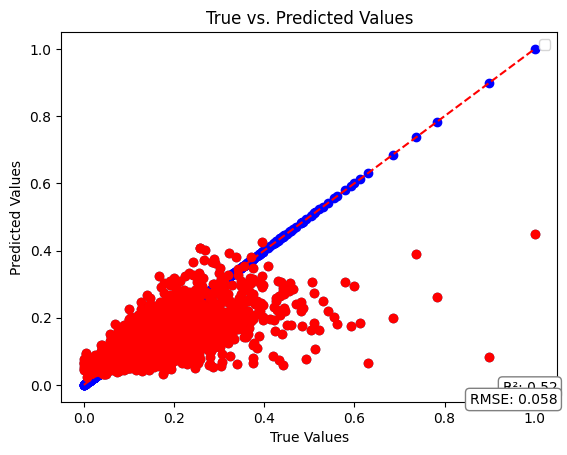

In [30]:
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values')
plt.scatter(y_test,y_test,color='blue')
plt.scatter(y_test,y_pred,color='red')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
box = dict(boxstyle="round, pad=0.3", fc="white", ec="gray", lw=1)
plt.text(plt.xlim()[1], plt.ylim()[0]+0.02, f"R²: {r2:.2f}", ha='right', va='bottom', wrap = True, bbox = box)
plt.text(plt.xlim()[1], plt.ylim()[0]*0.85 + 0.02, f"RMSE: {rmse:.3f}", ha='right', va='top', wrap = True, bbox = box) 
#rmse=5774,343
plt.legend()
plt.show()



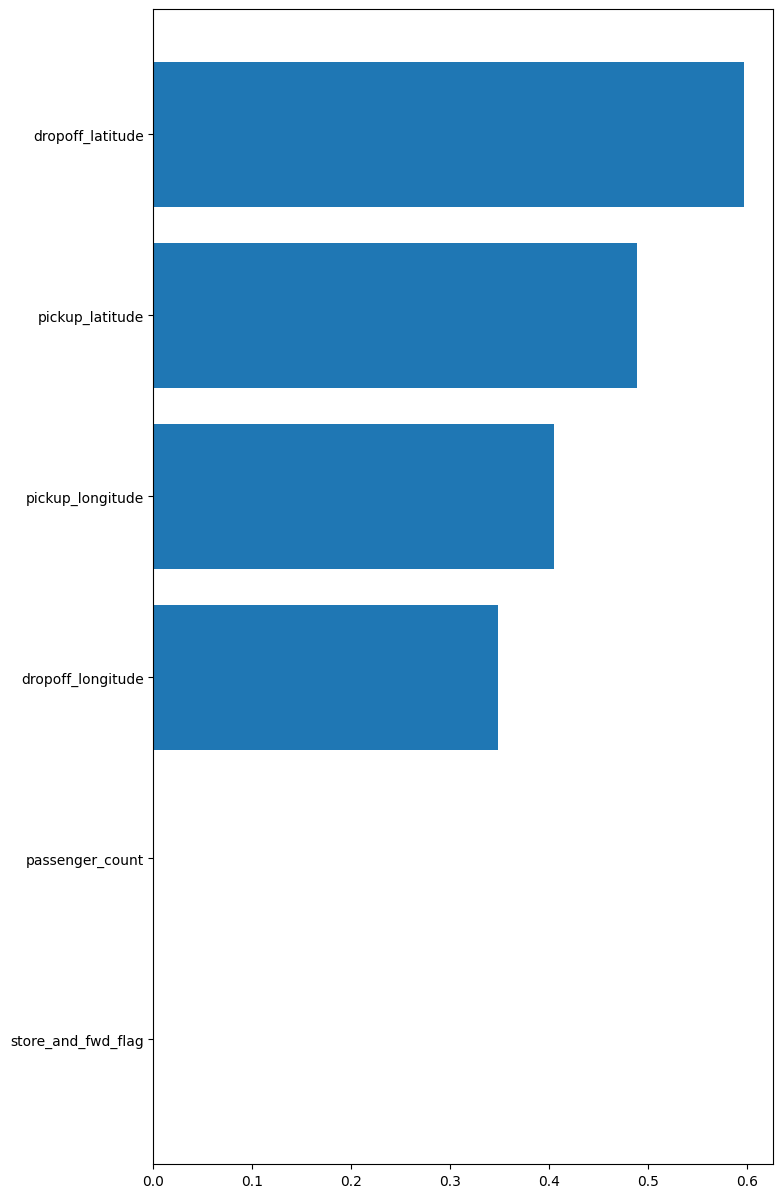

In [18]:
result = permutation_importance(model, X_test,y_test, n_repeats=7,random_state=7)

importance = result.importances_mean
feature_names = X_test.columns

indices = importance.argsort()[::1]
sorted_features = feature_names[indices]
sorted_importance = importance[indices]

fig, ax = plt.subplots(figsize = (8,15))
ax.barh(sorted_features,sorted_importance)
ax.set_yticklabels(sorted_features)
plt.show()


In an attempt to enhance the model's performance, we will test the best parameters obtained from the optimization process and explore potential adjustments to the model.

In [26]:
def objective(trial):
    params = {
        'loss':trial.suggest_categorical('loss',['squared_error','absolute_error','huber','quantile']),
        'n_estimators':trial.suggest_int('n_estimators',100,1000,step=50),
        'learning_rate':trial.suggest_loguniform('learning_rate',0.01,0.1),
        'max_depth':trial.suggest_int('max_depth',3,10),
        'min_samples_split':trial.suggest_int('min_samples_split',2,20),
        'min_samples_leaf':trial.suggest_int('min_samples_leaf',2,20),
        'subsample':trial.suggest_uniform('subsample',0.1,1.0),
        'random_state':7
    }

    tuning = GradientBoostingRegressor(**params)
    tuning.fit(X_train,y_train)
    preds = tuning.predict(X_test)

    rmse = np.round(mean_squared_error(y_test,preds,squared=False),3)
    return rmse


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5,show_progress_bar=True)

print('best parameters :',study.best_params)
print('best score :',study.best_value)


[I 2024-04-05 18:47:21,266] A new study created in memory with name: no-name-434077fa-4a9a-4a78-bb09-c468b6a129f8
Best trial: 0. Best value: 0.058:  20%|██        | 1/5 [00:17<01:11, 17.90s/it]

[I 2024-04-05 18:47:39,172] Trial 0 finished with value: 0.058 and parameters: {'loss': 'squared_error', 'n_estimators': 950, 'learning_rate': 0.04182888157149286, 'max_depth': 4, 'min_samples_split': 12, 'min_samples_leaf': 4, 'subsample': 0.2360308832432925}. Best is trial 0 with value: 0.058.


Best trial: 0. Best value: 0.058:  40%|████      | 2/5 [01:39<02:46, 55.61s/it]

[I 2024-04-05 18:49:01,184] Trial 1 finished with value: 0.068 and parameters: {'loss': 'quantile', 'n_estimators': 950, 'learning_rate': 0.016713021846937185, 'max_depth': 5, 'min_samples_split': 18, 'min_samples_leaf': 15, 'subsample': 0.9923354524788239}. Best is trial 0 with value: 0.058.


Best trial: 0. Best value: 0.058:  60%|██████    | 3/5 [02:43<01:58, 59.32s/it]

[I 2024-04-05 18:50:04,907] Trial 2 finished with value: 0.065 and parameters: {'loss': 'quantile', 'n_estimators': 600, 'learning_rate': 0.030176855981125465, 'max_depth': 7, 'min_samples_split': 15, 'min_samples_leaf': 14, 'subsample': 0.8473102416918176}. Best is trial 0 with value: 0.058.


Best trial: 0. Best value: 0.058:  80%|████████  | 4/5 [02:58<00:41, 41.70s/it]

[I 2024-04-05 18:50:19,596] Trial 3 finished with value: 0.06 and parameters: {'loss': 'huber', 'n_estimators': 500, 'learning_rate': 0.04529817008584147, 'max_depth': 4, 'min_samples_split': 15, 'min_samples_leaf': 14, 'subsample': 0.279505784785151}. Best is trial 0 with value: 0.058.


Best trial: 0. Best value: 0.058: 100%|██████████| 5/5 [04:22<00:00, 52.55s/it]

[I 2024-04-05 18:51:44,014] Trial 4 finished with value: 0.063 and parameters: {'loss': 'quantile', 'n_estimators': 950, 'learning_rate': 0.056034563948081, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 11, 'subsample': 0.5799212808468857}. Best is trial 0 with value: 0.058.
best parameters : {'loss': 'squared_error', 'n_estimators': 950, 'learning_rate': 0.04182888157149286, 'max_depth': 4, 'min_samples_split': 12, 'min_samples_leaf': 4, 'subsample': 0.2360308832432925}
best score : 0.058


Now, we will apply the best parameters obtained from the optimization process to our model and assess whether there is a notable improvement in performance.








No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


hello


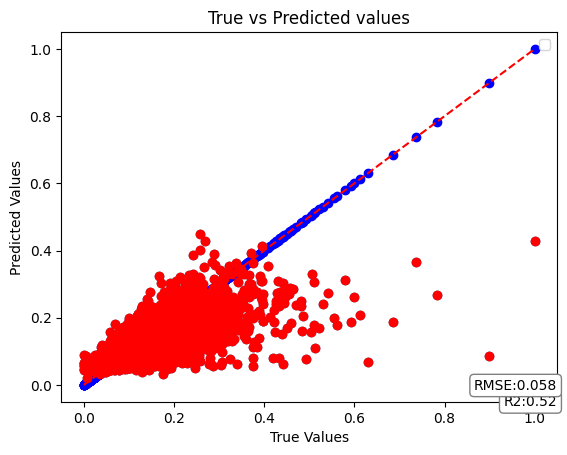

In [33]:
model = GradientBoostingRegressor(**study.best_params)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test,y_pred)
rmse = mean_squared_error(y_test,y_pred,squared=False)

plt.scatter(y_test,y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted values')
plt.scatter(y_test,y_test,color='blue')
plt.scatter(y_test,y_pred,color='red')
plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()],'r--')
box=dict(boxstyle="round",pad =0.3,fc='white',ec='gray',lw=1)
plt.text(plt.xlim()[1],plt.ylim()[0]+0.02,f"R2:{r2:.2f}",ha='right',va='top',wrap=True,bbox=box)
plt.text(plt.xlim()[1],plt.ylim()[0]*0.85+0.02,f"RMSE:{rmse:.3f}",ha='right',va='bottom',wrap=True,bbox=box)
print('hello')
plt.legend()
plt.show()